In [1]:
from __future__ import division

import numpy as np
from scipy.stats import nbinom, poisson
from math import log, exp, log10, floor

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set(style="white", palette="deep", color_codes=True)
sns.set_context("notebook", font_scale=1.2)
#plt.rcParams["axes.labelsize"] = 16

def force_aspect(ax, aspect=1):
    """force a matplotlib axis to have the specified aspect ratio on the screen"""
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    a = (np.max(xlim) - np.min(xlim)) / (np.max(ylim) - np.min(ylim))
    ax.set_aspect(a / aspect)
    
golden_ratio = 1.61803398875

In [2]:
import os
import errno

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [3]:
import pickle
import glob
import re

# Introduction

Fundamentally, we want to determine the probability that Madison wrote some piece of text, given that the word $w_i$ occurs $x_i$ times per 1,000 words.  This is a conditional probability, but it's often called the posterior probability -- in any case, I'll denote it as $P(\mathrm{M}\,|\,x_i)$.  We can use Bayes' theorem to rephrase the posterior probability in terms of the probability that *Madison* might have used the word $x_i$ times, *assuming* that he is the author.  Which is much easier to calculate:

\begin{equation}
P(\mathrm{M}\,|\,x_i) = \frac{P(x_i\,|\,\mathrm{M}) \; P(\mathrm{M})}{P(x_i)}
\end{equation}

So the problem boils down to calculating $P(x_i\,|\,\mathrm{M})$, the probability that Madison might have used the word $x_i$ times, given that he wrote the document.

In the last notebook, we computed this probability by assuming Madison's word usage follows the Poisson distribution.  This made the problem straightforward to calculate, but we also saw that the Poisson distribution cannot account for much of Madison's word usage; Madison occasionally changes the rate at which he uses certain words.  This can lead us to badly overestimate our certainty in authorship identification.

Here, I'll assume that Madison's word usage follows the negative binomial distribution.  This is a convolution of the Poisson distribution with the Gamma distribution, so you can interpret it as a Poisson distribution with a mean which drifts from one page to the next, following a Gamma distribution.  The negative binomial distribution should help us understand our uncertainty, for two reasons:
1. the negative binomial distribution has "fat tails," so it is less sensitive to outliers, and
2. as we'll see, word usage appears to actually follow the negative binomial distribution... like so much in science, it helps to use the right equation

The Poisson distribution has the interesting property that its mean and variance are identical: $\mu_{\text{P}} = \sigma^2_{\text{P}} = \lambda$.  The negative binomial distribution has a larger variance, which I'll write as
\begin{align}
\mu_{\text{NB}} &= \lambda \\
\sigma^2_{\text{NB}} &= \lambda (1+f),
\end{align}
so that $f$ represents the amount of "non-Poisson-ness" in the distribution.

The negative binomial distribution is usually written a bit differently, in terms of the parameters
\begin{align}
n &= \lambda / f \\
p &= \frac{1}{1 + f}
\end{align}
For this problem, $\lambda$ and $f$ are the more intuitive parameters, and the numerical results will also converge *much* faster if we use them.  (Actually, I use the parameters $\ln\lambda$ and $\ln{f}$).

We should get better results if we just redo the analysis in the previous notebook, replacing Poisson with negative binomial -- the more accurate distribution and the better handling of outliers should yield much more accurate results.  But the real improvement here will be an improved handling of our uncertainty.

Note that we want to calculate the likelihood function $P(x_i\,|\,\mathrm{M})$; i.e., the probability that word $w_i$ could occur $x_i$ times per 1,000 words, *given that Madison wrote them.*  But we can't actually calculate that!  What we can calculate it $P(x_i\,|\,\lambda_{i,\mathrm{M}}, f_{i,\mathrm{M}})$, i.e. the probability that word $w_i$ could occur $x_i$ times per 1,000 words, *given that Madison wrote them and that he follows a negative binomial distribution with the parameters $\lambda_{i,\mathrm{M}}$ and $f_{i,\mathrm{M}}$ for word $w_i$.*  This is of course not the same thing!

What we should do is integrate over the space of all possible models for Madison's writing:
\begin{equation}
P(x_i\,|\,\mathrm{M}) = \int P(x_i\,|\,\lambda_{i,\mathrm{M}},\,f_{i,\mathrm{M}}) \; P(\lambda_{i,\mathrm{M}},\,f_{i,\mathrm{M}}) \;\, d\,\lambda_i \; d\,f_i
\end{equation}
This should lead to a much more honest appraisal of our uncertainty.

But there are two problems:
1. This integral might be hard to do, and
2. We don't know the joint distribution $P(\lambda_{i,\mathrm{M}},\,f_{i,\mathrm{M}})$... all we have is the conditional probability $P(x_i\,|\,\lambda_{i,\mathrm{M}},\,f_{i,\mathrm{M}})$!

In the last notebook, I pulled a fast one on you and replaced this integral with the *mode* of the distribution (we got this by using scipy's minimize() function).  Here, I'll do the *right thing* and approximate this integral using a Markov Chain Montecarlo (MCMC) method. If done correctly, the MCMC simulation gives us a set of $n$ points drawn from the joint distribution $P(\lambda_{i,\mathrm{M}},\,f_{i,\mathrm{M}})$ (if you're not familiar with this method, you can essentially regard it as magic).  We can then approximate the integral above as an average over the points:
\begin{equation}
\int P(x_i\,|\,\lambda_{i,\mathrm{M}},\,f_{i,\mathrm{M}}) \; P(\lambda_{i,\mathrm{M}},\,f_{i,\mathrm{M}}) \;\, d\,\lambda_i \; d\,f_i
\sim \frac{1}{n} \sum_{j=1}^{n} P(x_i\,|\,\lambda_{i,\mathrm{M},j},\,f_{i,\mathrm{M},j})
\end{equation}
where the values are for word $w_i$ and the points in the joint distribution are labeled with index $j$.

Let's see how it works!

# First, start with an MCMC code to generate a sample consistent with the author's style

## Likelihood functions for the MCMC chain

In [4]:
import emcee

First, we need the likelihood function for the data; this is the conditional probability $P(x_i\,|\,\lambda_{i,M}, f_{i,M})$.  I'll estimate this using a modified $\chi^2$ test for compatibility between the negative binomial distribution with given parameters and the observed data.
    
Since I know this data can be extremely noisy, I'm fitting the empirical CDF (or EDF) to the theoretical CDF for the given parameters theta.  This is similar to the Kolmogorov-Smirnov test or the Anderson-Darling test.

And since I care about the tails of the distribution, the error is weighted by $C(x)\,(1-C(x))$; this corresponds to an estimate of the dispersion $\sigma^2 \sim \mathrm{min}[C(x), 1-C(x)] \sim P$, which is roughly Poisson-ish.  (If you're paying attention, you'll note that I weight the data here by $\sigma^3$.  This is just to make prettier plots... in the real calculation, I use $\sigma^2$.)

Note that these functions will be called $\sim10^7$ times, so it's important to make them as fast as possible!

In [5]:
def lnlike(theta, y):
    """log-likelihood for the data y, assuming a negative binomial
    distribution with the parameters theta = {ln(lambda), ln(f)}.
    
    N.B. y must be sorted in increasing order"""

    # start by constructing the empirical CDF
    # if this is a "stair-step" plot, we want the top-left corners of the steps
    # this way, EDF(x) is the fraction of points with value <= x
    #
    # TODO: this is the same for every step in the calculation... maybe it would be
    # faster to pre-compute it, and then re-use the results?  doesn't seem to be a 
    # bottleneck, though, since most of the cost is in the call to nbinom.cdf
    #
    # for my computer, lnlike takes 300 microseconds to run, of which 25 is 
    # computing the EDF
    #
    num = y.shape[0]
    edf = np.arange(1, num+1).astype(float) / num

    ind = np.where(np.diff(y) != 0)[0]
    pos = y[ind]
    obs = edf[ind]
    
    # now construct the theoretical CDF and evaluate it at the points 
    # where we have data
    #
    lam, f = np.exp(theta)
    n = lam / f
    p = 1.0 / (1.0 + f)
    model = nbinom.cdf(pos, n, p)
    
    err    = (model - obs)**2
    weight = model*(1.0-model)
    
    # since CDFs can get very close to 0 or 1...
    weight = np.clip(weight, a_min=0.01, a_max=None)
    
    return -np.sum(err / weight**1.5)

In [6]:
def lnprior(theta, y):
    """Prior distribution for the parameters theta.

    First, enforce that the parameters are valid.

    Next, impose a weak preference that the distribution mean should match
    the mean of the data, in case there are degeneracies."""
    lnlam, lnf = theta
    lam,   f   = np.exp(theta)
    
    # lnf < -2 makes little-to-no difference, so don't waste computation
    # exploring that space
    if lnlam <= -10 or lnf <= -2 or lnf >= 3:
        return -np.inf
    
    va = lam * (1.0 + f)
    
    mu_1 = np.mean(y)
    va_1 = np.var(y)
    
    return -(lam-mu_1)**2 / (2*(va_1+va))

In [7]:
def lnprob(theta, y):
    """Overall log-probability function is the sum of the
    prior probability and the likelihood"""
    lp = lnprior(theta, y)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike(theta, y)

## Function to plot MCMC results (sorry it's a slog!)

In [8]:
def plot_sample(data, s, 
                lnlam_0, lnf_0,
                accept_frac, auto_cor,
                word, show=False, plot_save_dir='mcmc-figures'):
    """Plot the MCMC chain to assess convergence, along with how well
    it matches the data.
    
    There are a number of unjustified assumptions in this model, so 
    checking the fits is essential!"""
    
    # make a big plot and split it into a grid with 6 rows and 3 columns
    #
    fig=plt.figure(figsize=(12, 12))
    gs=GridSpec(6,3)

    # first, show "trace" plots along the top of the figure
    #
    ax1=fig.add_subplot(gs[0,:]) # first row, all columns
    ax2=fig.add_subplot(gs[1,:]) # second row, all columns

    for ax in [ax1, ax2]:
        ax.set_xlim([0, s.shape[0]])

    ax1.plot(s[:,0])
    ax1.set_xticks([])
    ax1.set_ylabel("$\ln\,\lambda$")
    
    ax2.plot(s[:,1])
    ax2.set_ylabel("$\ln\,f$")

    # next, show histograms of the parameters...
    #
    ax3=fig.add_subplot(gs[2:4,0]) # two rows high, one column wide
    ax4=fig.add_subplot(gs[2:4,1])
    ax5=fig.add_subplot(gs[2:4,2])

    for ax in [ax3, ax4]:
        ax.set_yticks([])

    sns.distplot(s[:,0], kde=False, bins=50, axlabel='$\ln\,\lambda$', ax=ax3)
    sns.distplot(s[:,1], kde=False, bins=50, axlabel='$\ln\,f$',       ax=ax4)
    
    # add initial guesses to gauge burn-in
    ax3.axvline(x=lnlam_0, color='0.3', linewidth=2)
    ax4.axvline(x=lnf_0,   color='0.3', linewidth=2)

    # ...and a joint distribution
    #
    sns.kdeplot(s[:,0], s[:,1], shade=True, cmap="Blues", ax=ax5)
    ax5.set_xlabel("$\ln\,\lambda$")
    ax5.set_ylabel("$\ln\,f$")

    # finally, show the data along with a sample of model fits
    #
    ax6=fig.add_subplot(gs[4:6,:]) # two rows high, all columns
    
    xmax = np.max([np.max(data), 1])
    ax6.set_xlim([0, xmax])
    ax6.set_ylim([0,1])

    # plot a random sample from the MCMC chain
    #
    xl = np.arange(0, xmax+1) # must be integers
    for lnlam, lnf in s[np.random.randint(len(s), size=500)]:
        n = exp(lnlam) / exp(lnf)
        p = 1.0 / (1.0 + exp(lnf))
        yl=nbinom.cdf(xl, n, p)
        ax6.plot(xl, yl, color="k", alpha=0.05)

    # plot a Poisson distribution for comparison
    #
    yl = poisson.cdf(xl, np.mean(data))
    ax6.plot(xl, yl, color="g", linewidth=3, label="Poisson")

    # finally, make an empirical CDF (EDF) to plot
    #
    x = np.sort(data)
    y = np.arange(1,data.shape[0]+1).astype(float)/data.shape[0]

    # find the points where the EDF is actually defined!
    ind = np.where(np.diff(x) != 0)[0]

    # make a "stair-step" plot by repeating each index
    x1 = np.repeat(x[ind], 2)[1:]
    y1 = np.repeat(y[ind], 2)[:-1]
    ax6.plot(x1, y1, linewidth=3, label="data")
    ax6.plot(x[ind], y[ind], 'o', color='c')

    # show a legend and print some information in the plot title
    #
    ax6.legend(loc=2)
    plt.suptitle("$N$ = {0:d}, $\mu$ = {1:.2g}, $\sigma^2$ = {2:.2g}, \n acceptance fraction = {3:.2g}, autocorrelation time = {4:.2g}"\
                 .format(np.sum(data), np.mean(data), np.var(data),
                         accept_frac, auto_cor))

    # leave room for title at the top
    gs.tight_layout(fig, rect=[0, 0, 1, 0.935])
  
    make_sure_path_exists(plot_save_dir)
    plt.savefig('{0}/{1}.png'.format(plot_save_dir, word))
    
    # show means we see it in the jupyter notebook
    if not show:
        plt.close();

## Run the MCMC simulation and return a sample of models consistent with the data

In [12]:
def make_sample(data, word, mkfig=True, showfig=False, plot_save_dir='mcmc-figures'):
    """Runs the MCMC simulation and returns a sample of models which
    are consistent with the data.
    
    saves a plot with name 'word.png' in plot_save_dir/ if mkfig is True
    
    shows the plot in notebook if showfig is True"""
    
    # parameters for the MCMC simulation
    ndim, nwalkers = 2, 24

    # first two empirical moments of the distribution
    mu = np.mean(data)
    va = np.var(data)

    # if the word *never* occurs in any of the samples, we have no data to fit!
    # return a Poisson-ish distribution with the upper limit on the rate
    if mu <= 0:
        data[-1] = 1
        mu = np.mean(data)
    
    # initial guess for the negative binomial distribution based on mean and
    # variance of the distribution
    lam_0 = mu
    f_0   = np.max([va/mu - 1.0, exp(-1)])

    lnlam_0 = log(lam_0)
    lnf_0   = log(f_0)
        
    def mkpos_helper():
        return [lnlam_0 + 1.0*np.random.randn(),
                lnf_0   + 1.0*np.random.randn()]

    def mkpos(y):
        ret  = mkpos_helper()
        prob = lnprior(ret, y)
        while not np.isfinite(prob):
            ret  = mkpos_helper()
            prob = lnprior(ret, y)
        return ret

    p0 = [ mkpos(np.sort(data)) for i in range(nwalkers) ]
    
    # todo: figure out how to use multiprocessing in a jupyter notebook
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[np.sort(data)])

    # burn in for 2000 steps
    pos, prob, state = sampler.run_mcmc(p0, 2000)
    sampler.reset()
    
    # there's an interesting debate over whether to thin MCMC chains based
    # on the autocorrelation... after a bit of reading, i came to the conclusion
    # that it's best not to thin in most cases since the benefit from removing
    # correlations is overwhelmed by the loss of data.  however in this case, it's
    # not practical to use the full MCMC chain anyways... so i may as well thin it
    # and remove correlations so we can all sleep better at night.  the conservative
    # estimate for the correlation length seems to be about 30-40, so i thin the
    # chain to every 50th cell
    #
    # see, eg, http://doingbayesiandataanalysis.blogspot.de/2011/11/thinning-to-reduce-autocorrelation.html
    #
    for pos, prob, state in sampler.sample(pos, iterations=8000, thin=50, storechain=True):
        pass;
    samples = sampler.flatchain
    
    if mkfig:
        plot_sample(data, samples, 
                    lnlam_0, lnf_0,
                    np.mean(sampler.acceptance_fraction),
                    np.mean(sampler.acor),
                    word, showfig, plot_save_dir)
        
    return samples[np.random.randint(len(samples), size=500)]

## Quick sanity check: let's test it out on a few example words!

First, try it out on a fairly common word:

In [13]:
%%timeit -n 1 -r 1
s = make_sample(
    np.array([13, 24, 30, 20, 16, 13, 11,  9,  5, 13, 16, 15, 11, 18,  6, 19, 15, 23, \
              17, 30,  9, 17, 22,  9, 23, 25, 34, 21, 21, 14, 18, 14, 15, 19, 17, 19, \
              24, 21, 14, 20, 18, 14, 17, 37, 22]),
    "through",
    False, False);

1 loop, best of 1: 1min 42s per loop


1 loop, best of 1: 1min 45s per loop


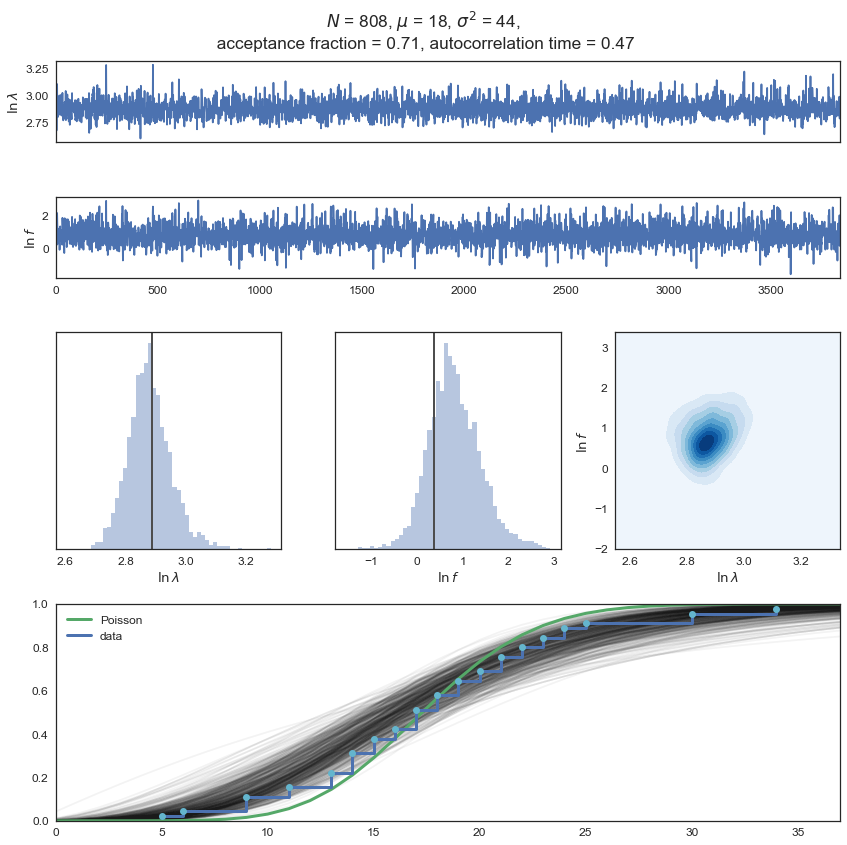

In [14]:
%%timeit -n 1 -r 1
plot_save_dir = 'mcmc-test-figs'
s = make_sample(
    np.array([13, 24, 30, 20, 16, 13, 11,  9,  5, 13, 16, 15, 11, 18,  6, 19, 15, 23, \
              17, 30,  9, 17, 22,  9, 23, 25, 34, 21, 21, 14, 18, 14, 15, 19, 17, 19, \
              24, 21, 14, 20, 18, 14, 17, 37, 22]),
    "through",
    True, True,
    plot_save_dir);

Here, we have pretty good statistics on the word usage, and therefore relatively little uncertainty in what we should be fitting.  The bundle of black lines represents my set of "Madison-like" models, and should be compared to the black points.

Note that the Poisson distribution goes very quickly to zero in the tails of the distribution -- this is not consistent with the data, and it would imply a very low probability that Madison wrote his own work!

Note that the distributions for $\lambda$ and for $f$ indeed look fairly log-normal, and that the joint distribution looks nice and bull's-eye-like... this suggests that my choice of the coordinates $\ln\,\lambda$ and $\ln\,f$ is a good one.  I've confirmed that the convergence is *much* slower with linear and log-linear coordinates.  It's even worse with the negative binomial parameters $n$ and $p$.

Next, note that this calculation takes $\sim{2}$ minutes per word, and that we have $\sim{250}$ words per author, so we're looking at $\sim{8}$ hours to build an author model.  My parameter choices are clearly overkill, and I could probably cut that down by a factor of $4$ or so... but the entire point of this exercise is to have rock-solid results, with a clear understanding and quantification of our uncertainty.  So I'm not going to sacrifice quality for speed here!  Instead, I'll run the Markov simulations elsewhere on a computer cluster such as the google compute cloud.  Author models take about 15 minutes to run on 16 modern cores, for which Google charges about $0.14.  I'll happily take two author models for a quarter!

Next, we'll try a less common word:

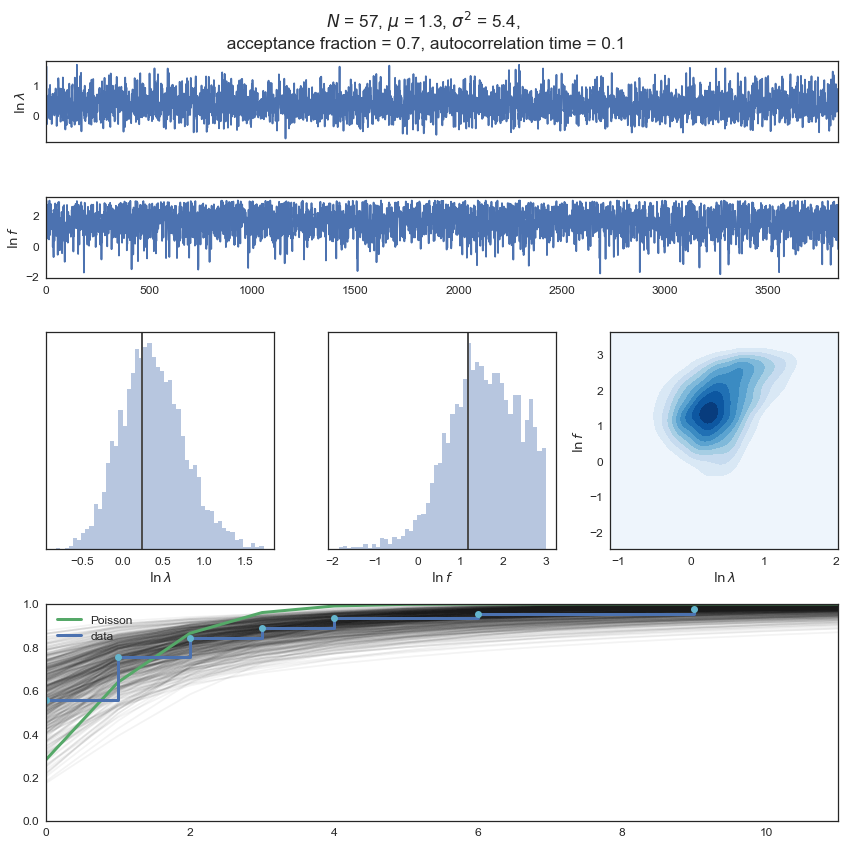

In [16]:
plot_save_dir = 'mcmc-test-figs'
s = make_sample(
    np.array([4, 4,  0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 9, 1, 1, 3, 0, 0, 1, 0, 0, 0, 2, \
              1, 6, 11, 1, 2, 0, 1, 0, 0, 0, 1, 2, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0]),
    "his",
    True, True,
    plot_save_dir)

Here, the mean occurrence is only about once per thousand words, but madison does occassionally use it six, or even nine times per thousand words!  Again, the Poisson distribution cannot accomodate this, and would strongly imply that Madison didn't write his own work.  The negative binomial curves seem to fit the data, and the appreciable spread in the curves reflects the limited data we have to constrain them

Next, we'll try a word that *is* roughly consistent with the Poisson distribution:

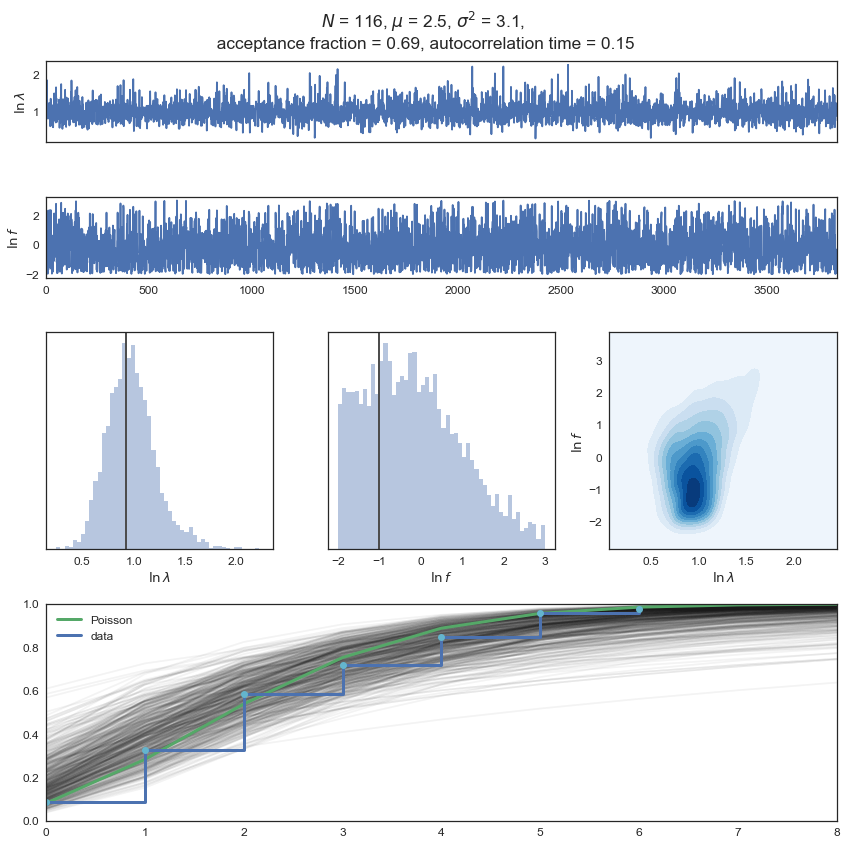

In [17]:
s = make_sample(
    np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, \
              2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 8]),
    "than",
    True, True,
    plot_save_dir)

Here, the model indeed reproduces the Poisson model, with $\ln(f)<0$.  It does, however, also gives a sense of the uncertainty in the mean, and it does allow for *some* non-Poisson-ness, since after all we don't have all that much data.

And just for good measure, we should try it with a word which *barely* occurs, to make sure we do something reasonable in this corner-case:

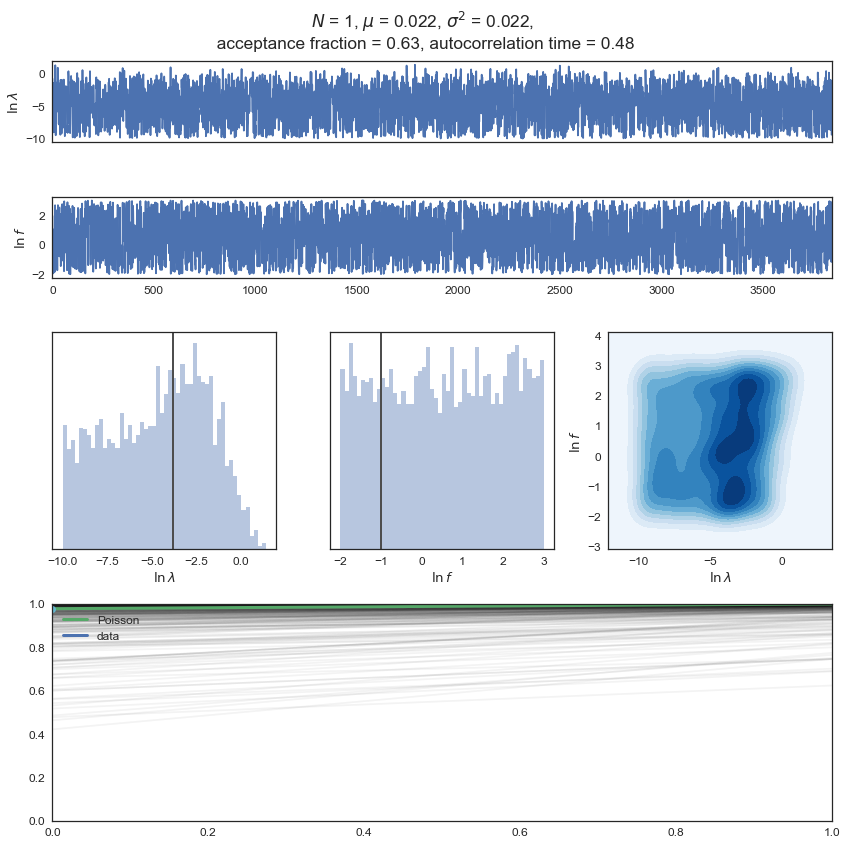

In [18]:
s = make_sample(
    np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, \
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "about",
    True, True,
    plot_save_dir)

Here, the model is not well-constrained, since we have essentially no data to work with... all we know is that, whatever $\lambda$ is, it should be small.

# Now that we can estimate distributions of word usage, we can use it to build models for each of the authors

In [94]:
import nltk
from collections import Counter

## First, define the stop words we'll use in our analysis

The key here is to use *function words*, which are hopefully independent of context.  We want a good sample of both rare words, which may be more idiosyncratic and therefore better able to disambiguate authors, and also more common words, which have better statistics and may yield more information, even if the usage patterns are more uniform.

In general, I expect the final probabilities will end up resulting from many small probabilities all adding up

In [95]:
stopwords = ["a", "about", "above", "according", "across", "affect", "after", \
"again", "against", "all", "almost", "alone", "along", "already", \
"also", "although", "always", "among", "an", "and", "another", "any", \
"anyone", "anything", "anywhere", "apt", "are", "argue", "around", \
"as", "asserted", "at", "back", "be", "became", "because", "become", \
"becomes", "been", "before", "behind", "being", "better", "between", \
"both", "but", "by", "can", "cannot", "common", "commonly", \
"comparable", "consequently", "considerable", "could", "course", \
"degree", "did", "do", "done", "down", "dramatically", "during", \
"each", "either", "enough", "even", "ever", "every", "everyone", \
"everything", "everywhere", "extent", "few", "find", "first", \
"follow", "for", "four", "from", "full", "further", "get", "give", \
"go", "had", "has", "have", "he", "hence", "her", "here", "herself", \
"him", "himself", "his", "how", "however", "if", "imply", \
"importance", "in", "interest", "into", "is", "it", "its", "itself", \
"join", "keep", "kind", "largely", "last", "least", "less", "made", \
"many", "may", "me", "might", "more", "moreover", "most", "mostly", \
"much", "must", "my", "myself", "necessary", "never", "next", "no", \
"nobody", "noone", "nor", "not", "nothing", "now", "nowhere", "of", \
"off", "often", "on", "once", "one", "only", "or", "other", "others", \
"our", "out", "over", "part", "particularly", "per", "perhaps", \
"possible", "principle", "put", "rather", "requisite", "same", \
"second", "see", "seem", "seemed", "seeming", "seems", "several", \
"shall", "she", "should", "show", "side", "since", "so", "some", \
"someone", "something", "somewhere", "still", "substance", "such", \
"suggest", "take", "than", "that", "the", "their", "them", "then", \
"there", "therefore", "these", "they", "thing", "this", "those", \
"though", "three", "through", "throughout", "thus", "to", "together", \
"too", "toward", "two", "typical", "typically", "under", \
"unexpected", "until", "up", "upon", "us", "use", "using", "very", \
"was", "we", "well", "were", "what", "when", "where", "whether", \
"which", "while", "whilst", "who", "whole", "whose", "why", "will", \
"with", "within", "without", "would", "yet", "you", "your", "yours"]

## Function to tally words in the "training set;" this is the data we'll feed into the MCMC simulations

Since we need to know the shape of the distribution, it's important to measure both the mean and the variance.  I'll divide the corpus into chunks of 1000 words so that we can measure both.  This choice is arbitrary, but I think it's reasonable.

In [4]:
def train(filename):
    """Take a large corpus of text, break it up into chunks of 1000 words,
    and tally each of the stop words in each of the chunks.

    Returns a list.  Each element in the list corresponds to one stopwords;
    it is an array in which the elements count the number of instances of
    that word in each of the chunks."""

    with open(filename, 'r') as f:
        raw = f.read()

    all_words = nltk.word_tokenize(raw.lower())

    n=1000
    samples = [ all_words[i:i + n] 
                for i in xrange(0, len(all_words), n) ]

    c = [ Counter(s) for s in samples ]
    x = [ [cc[w] for w in stopwords] for cc in c ]

    # transpose and return
    return map(list, zip(*x))

## Make the author models!

Since this is computationally expensive, we'll run these on the Google "compute engine" and save the data in serialized pickles.  The whole thing should take about a half hour on 16 cores.  Google charges about \$0.33 if you run it as a normal job, or \$0.07 if you run it as a "preemptible" job.

In [ ]:
# don't run this cell... it will take 16 hours!
# instead, use gcloud/mcmc.py, which is parallelized.
#
xm = train('../authors/madison-corpus-small.txt')
xh = train('../authors/hamilton-corpus-small.txt')

mad_model = [ make_sample(x, word, mkfig=False) for x, word in zip(xm, stopwords) ]
ham_model = [ make_sample(x, word, mkfig=False) for x, word in zip(xh, stopwords) ]

with open('mad-short.samples.pickle', 'wb') as handle:
    pickle.dump(mad_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('ham-short.samples.pickle', 'wb') as handle:
    pickle.dump(ham_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [106]:
# run this instead:
#
with open('gcloud/author-models/mad-all.pickle', 'rb') as handle:
    mad_model = pickle.load(handle)

with open('gcloud/author-models/ham-all.pickle', 'rb') as handle:
    ham_model = pickle.load(handle)

# Authorship Identification

Now, we get to the fun part!  We can use the MCMC chains we've built to try and identify the authors of the contested Federalist papers.  While the authorship isn't so much in doubt anymore, this analysis should provide a better and more honest assessment of the uncertainty in our determinations

## first, measure word frequencies in the federalist papers:

For verification, we'll measure all of the ones known to be written by madison or hamilton, and we'll also measure the disputed papers.

In [91]:
def measure(filename):
    with open(filename, 'r') as f:
        raw = f.read()

    all_words = nltk.word_tokenize(raw.lower())
    num = len(all_words)

    c = Counter(all_words)
    x = [ c[w] for w in stopwords ]
    
    return (x, num)

In [96]:
mad_papers = [ measure(f) for f in glob.glob('../authors/madison/*.txt') ]
ham_papers = [ measure(f) for f in glob.glob('../authors/hamilton/*.txt') ]
u_papers   = [ measure(f) for f in glob.glob('../authors/unknown-federalist/*.txt') ]

## Posterior probability that an author wrote the given document:

In [115]:
def prob(x, num, sample):
    """ probability for a single word to occur x times in num words of text,
    given the author model defined by the MCMC chain in sample."""
    sample = sample[:50] # keep only 50 samples for speed
    ps =  np.zeros(len(sample))
    for i, theta in enumerate(sample):
        lam, lnf = theta
        f = exp(lnf)
        lam = lam * (num/1000) # scale model rate to the length of the paper
        n = lam / f
        p = 1.0 / (1.0 + f)
        ps[i] = nbinom.pmf(x, n, p)

    return log(np.mean(ps))

def all_prob(obs, model):
    xs, num = obs
    return np.sum([prob(x, num, sample) for x, sample in zip(xs, model)])

## First, confirm the model against the training data:

We can crudely check the model by making sure it correctly classifies each of the papers it was trained on.  (This is a *minimal* check!)

In [116]:
%%timeit -n 1 -r 1
mad_results = [ all_prob(obs, mad_model) - all_prob(obs, ham_model) for obs in mad_papers ]

print "Should all be positive:"
print np.round(mad_results, 1)

Should all be positive:
[ 17.1  26.5  25.5  23.9  27.5  24.7  15.8  22.8  21.6   9.7  30.2  23.
  13.   19.8  30.5]
1 loop, best of 1: 1min 20s per loop


In [117]:
%%timeit -n 1 -r 1
ham_results = [ all_prob(obs, ham_model) - all_prob(obs, mad_model) for obs in ham_papers ]

print "Should all be positive:"
print np.round(ham_results, 1)

Should all be positive:
[ 19.6  37.9  20.7  22.7  50.5  10.5  24.   24.   33.   22.5  19.7  14.6
  37.1  32.4  26.1   8.6  15.5  27.8  21.6  29.1  21.2  26.4  20.3  18.8
  29.2  26.1   9.6  22.8  25.1  34.2  33.6  27.6  36.8  21.9  19.4  29.
  31.3  30.5  26.   13.5  15.7  25.6   9.8  30.   14.9  18.3  24.7  27.9
  23.2  10.6  33.8]
1 loop, best of 1: 4min 32s per loop


## ... and check the contested papers!

In [118]:
%%timeit -n 1 -r 1
u_results = [ all_prob(obs, mad_model) - all_prob(obs, ham_model) for obs in u_papers ]

print "Disputed Papers:"
print "Positive if Madison wrote them, negative if Hamilton:"
print np.round(u_results, 1)

Disputed Papers:
Positive if Madison wrote them, negative if Hamilton:
[ 18.7  14.6   7.3  10.8  11.2  22.7  14.4  19.1  12.1   3.2   9.9   8.3
  10.7  12.3]
1 loop, best of 1: 1min 14s per loop


Great... it looks like Madison wrote all of the contested papers, with typical odds of $\exp(10) \sim$ 22,000:1.  This is a reasonable conclusion (since it confirms my prejudice), and I think these odds are much more reasonable than the quadrillions-to-one (or even more) that we saw earlier.  The weakest determination is, as always, for Federalist #55, for which we have odds of $\exp(3.2) \sim$ 25:1... I think this much lower certainty is reasonable, given the apparent trouble that our support vector machine had with this pesky paper.  So this is progress!  One last check, and I think I can say we have the best determination of the authorship to date:

# check the honesty of our odds ratios

The crucial feature of this code is that it not only identifies the most likely author of a piece of work, but that *it quotes a meaningful probability that its identification is correct*... at least, that's what I've claimed!  Before we get too excited about these determinations, we should confirm that my quoted odds are in fact correct.

There are only 14 disputed Federalist papers to try, so even my lowest quoted odds of 25:1 will be hard to check empirically!  Fortunately, we can test the code by repeatedly running it on smaller and smaller fragments of text with known authorship.  When I make the fragments small enough, eventually the code should start making errors.  Hopefully, it should also report similarly smaller confidences.

Since running the code tens of thousands of times is expensive, I've again run this on the google compute engine... if you want, you can take a look at the file gcloud/check-errors.py to see how I did this.  In this notebook, we'll only take a look at the results:

In [19]:
from scipy.stats import beta
from collections import Counter

In [20]:
def process_error(errorfile):
    # errorfile produced by 'check-errors.py'
    # - format is a 4xn array, where n is the total number of fragments checked
    # - rows are madison fragment length, madison result,
    #   hamilton fragment length, hamilton result
    # - for the results, a positive number indicates a correct determination
    #   and a negative number signals a misidentification.  magnitude is the
    #   quoted log-probability
    #
    with open(errorfile, 'rb') as f:
        mlen, mresults, hlen, hresults = pickle.load(f)
        
    # split into correct and incorrect determinations
    #
    allresults = np.concatenate([mresults, hresults])
    correct   = allresults[np.where(allresults > 0)]
    incorrect = allresults[np.where(allresults < 0)] * -1

    # tally correct and incorrect results as a function of predicted log odds,
    # flooring the log-odds to an integer
    #
    inc = Counter(np.floor(incorrect).astype(int))
    cor = Counter(np.floor(  correct).astype(int))
    
    all_odds_obtained = set(cor.elements()) | set(inc.elements())
    
    # empirical correct fraction
    correct_frac = [ cor[odds] / (cor[odds] + inc[odds])
                     for odds in all_odds_obtained ]

    # estimate the uncertainty in the success fraction:
    #
    # you can use Bayesian and Binomial statistics to infer an error interval
    # the probability for the "true" success rate, based on an observation
    # of s successes and f failures, is a beta distribution.  no need to go
    # into the details here, but it's a neat calculation and you can see the
    # resulting formula on this wiki page:
    # https://en.wikipedia.org/wiki/Checking_whether_a_coin_is_fair
    #
    # plot the 95% confidence interval:
    #
    intervals = [ beta(cor[odds]+1, inc[odds]+1).interval(0.95) 
                  for odds in all_odds_obtained ]

    medians   = [ beta(cor[odds]+1, inc[odds]+1).median()
                  for odds in all_odds_obtained ]
    
    ret = [ (odds, frac, median, median-interval[0], interval[1]-median)
            for odds, frac, median, interval 
            in zip(all_odds_obtained, correct_frac, medians, intervals) ]
    
    # transpose and return
    return np.asarray(ret).T

In [29]:
def histogram_study(errfile, odds_reduction=1.0):

    odds, frac, med, err_m, err_p = process_error(errfile)

    def my_histogram(odds, frac, ax):
        """custom histogram plot to show successes and failures"""
        # first define some colors
        pal = sns.color_palette("RdBu", n_colors=7)
        fail_color, missing_color, success_color = pal[0], pal[5], pal[6]

        # plot successful inferences
        ax.bar(odds, frac,
               color=success_color, width=1, align='edge')

        # plot failed inferences
        ax.bar(odds, 1.0-frac, bottom=frac,
               color=fail_color, width=1, align='edge', label='failed prediction')

        # plot missing data
        missing = set(np.arange(np.max(odds))) - set(odds)
        ax.bar(list(missing), [1.0] * len(missing),
               color=missing_color, width=1, align='edge', label='missing data')

    # make a 2x2 plot
    #
    fig=plt.figure(figsize=(12, 12))
    gs=GridSpec(1,2) # two rows, two columns

    ax1=fig.add_subplot(gs[0,0])
    ax2=fig.add_subplot(gs[0,1])

    my_histogram(odds, frac, ax1)

    ax1.errorbar(odds+0.5, med, yerr=[err_m, err_p],
                 fmt='o', marker=None, color='0.15', elinewidth=3)

    ax1.set_ylim([0.0,  1.0]);
    ax1.set_xlim([0.0, 10.0]);

    # plot the implied success fraction, based on the inferred log-odds
    # reduce the odds by an optional factor odds_reduction
    x = np.linspace(0.5, 10.0, 50)
    y = 1.0 / (1.0 + np.exp((x-0.5) / odds_reduction))
    ax1.plot(x, 1.0-y, color='0.75', linewidth=4, label='claimed accuracy')

    ax1.set_xlabel('log odds')
    ax1.set_ylabel('correct fraction')
    ax1.legend(loc='lower right')


    # next, re-plot the histogram over a wider range of data, mostly so that we
    # can see a lot of successes and then feel good about ourselves
    my_histogram(odds, frac, ax2)

    ax2.set_ylim([0.0,1.0]);
    ax2.set_xlim([0.0, 60.0]);

    ax2.set_xlabel('log odds')
    ax2.set_ylabel('correct fraction');

    force_aspect(ax1, golden_ratio)
    force_aspect(ax2, golden_ratio)

    plt.show()

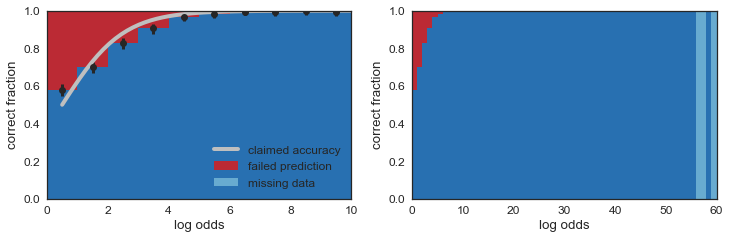

In [30]:
# full training set of attributed papers of 150k words, checked against
# the full set of federalist papers.
# this leaves 100% overlap for hamilton, and nearly 50% overlap for madison,
# so it's not technically an honest test of the method.
#
histogram_study('gcloud/errors/full-set-overlap.pickle')

This looks good!  But it also might be cheating, since I'm testing the model on much of the same data that I trained the model on.  We can instead try it using a separate model, which was not trained on any of the data I use for testing:

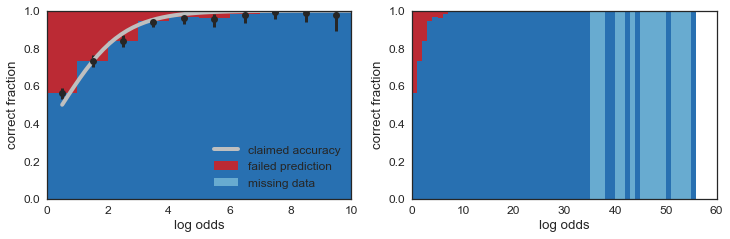

In [31]:
# training set of ~40k words, testing set of ~25k words, no overlap
histogram_study('gcloud/errors/large-training-set-no-overlap.pickle')

not bad!  This is very impressive agreement, and it suggests that when the code gives 100:1 odds, we can be confident that the determination is in fact correct 99% of the time!

Finally, for good measure, let's see what happens when we're somewhat starved for data:

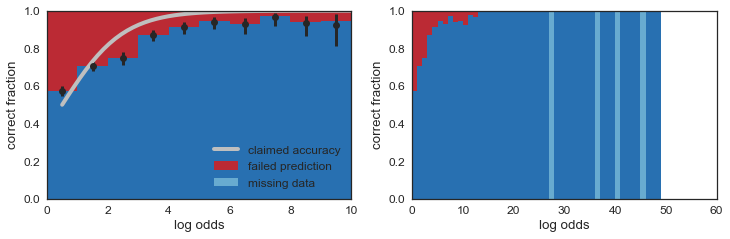

In [32]:
# training set of ~25k words, testing set of ~40k words, no overlap
histogram_study('gcloud/errors/small-training-set-no-overlap.pickle')

Doh!  There are fragments for which I quote a log-probability of 10 (22,000:1 odds), but which are only correct 95% of the time.  95% accuracy *is* pretty impressive, especially for such a hard problem and using such little data, but it also means that I've overstated my certainty *by a factor of 1000*.  And that's despite so many attempts to be conservative!

I think this again comes down to selection (or regression) effects, which I neglected because I fit Madison and Hamilton independently.  This can artifically give extra weight to words which (randomly) happen to differentiate them in the training set, leading to over-stated certainty in the reported fit.  I should simultaneously fit for Madison and Hamilton, with a prior on $\tau = \lambda_{\text{M}} / (\lambda_{\text{M}} + \lambda_{\text{H}})$, as we did in the Poisson example.  (Ironically, while I undertook this notebook to *improve* on Mosteller & Wallace's calculation, I made the mistake of neglecting their most important insight!)

Fixing this is easy enough to do, and we'll check it in the next notebook.  But for now, I think we can be reasonably secure in results which build off from a training set of 40,000 words or more.